# Project 2 - Ames Housing Data and Kaggle Challenge

# Data Import and Cleaning

In [1]:
#import all the libraries used

import datetime
import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import combinations
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,LabelEncoder
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn')
#sns.set(style="white", color_codes=True)
#colors_palette = sns.color_palette("GnBu_d")
#sns.set_palette(colors_palette)
from ipywidgets import *
from IPython.display import display


from cycler import cycler

# Seaborn is behind matplotlib on updates
import warnings
warnings.filterwarnings('ignore')

# Load the Data

In [2]:
df_train = pd.read_csv('./datasets/train_clean1.csv')
df_test = pd.read_csv('./datasets/test_clean1.csv')

## Data Cleaning : remove outliers 
Observation to removed hints from datadocumentation : http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

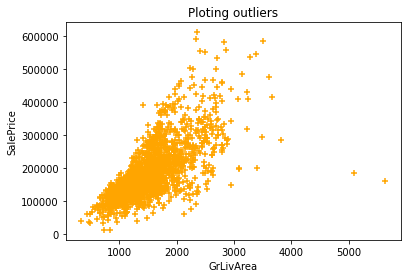

In [3]:
#a plot of SALE PRICE versus GR LIV AREA 

plt.scatter(df_train['Gr Liv Area'], df_train.SalePrice, c = "orange", marker = "+")
plt.title("Ploting outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()


In [4]:
#drop any houses with more than 4000 square feet as these are outliers 
#drop 2 rows 
df_train = df_train[df_train['Gr Liv Area'] < 4000]

In [5]:
df_train.shape

(2049, 72)

In [6]:
df_test.shape

(879, 71)

# Exploratory Data Analysis

## Data cleaning :  Investagation on Sale Price

In [7]:
#sale price has a large range from 12789 to 611657, mean is 181479. check if there is any outliers
df_train['SalePrice'].describe() 

count      2049.000000
mean     181479.018058
std       79295.913255
min       12789.000000
25%      129800.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

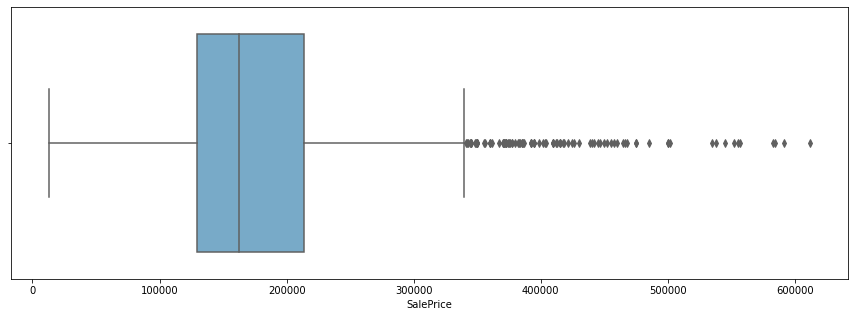

In [8]:
plt.figure(figsize = (15, 5))
sns.boxplot('SalePrice', data = df_train, palette = 'Blues');

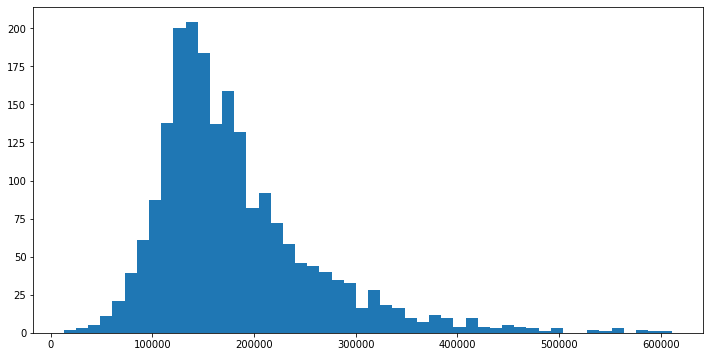

In [9]:
#dist of the sale price, we can see that most of the price distribution are in between 100,000-400,000

plt.figure(figsize=(12,6))
plt.hist(df_train['SalePrice'],bins=50)
plt.show()

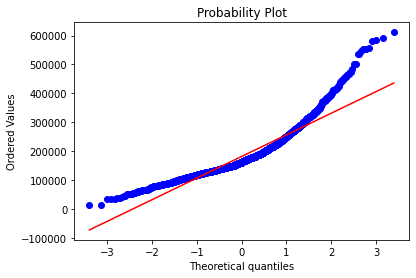

In [10]:
#QQ plot before log scale
from scipy import stats
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

In [11]:
df_train[df_train['SalePrice'] > 550000]

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Mo Sold,Yr Sold,Sale Type,SalePrice
151,2333,60,RL,85.0,16056,Pave,IR1,Lvl,AllPub,Inside,...,Y,214,108,0,0,0,7,2006,New,556581
623,457,20,RL,100.0,14836,Pave,IR1,HLS,AllPub,Inside,...,Y,226,235,0,0,0,2,2009,WD,552000
1164,424,20,RL,105.0,15431,Pave,Reg,Lvl,AllPub,Inside,...,Y,0,72,0,0,170,4,2009,WD,555000
1671,45,20,RL,100.0,12919,Pave,IR1,Lvl,AllPub,Inside,...,Y,0,67,0,0,0,3,2010,New,611657
1692,2451,60,RL,114.0,17242,Pave,IR1,Lvl,AllPub,Inside,...,Y,870,86,0,0,210,5,2006,WD,584500
1796,434,60,RL,107.0,13891,Pave,Reg,Lvl,AllPub,Inside,...,Y,52,170,0,0,192,1,2009,New,582933
1964,1638,20,RL,52.0,51974,Pave,IR1,Lvl,AllPub,CulDSac,...,Y,0,135,0,0,322,6,2007,New,591587


In [12]:
df_train.head()

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,60,RL,69.0552,13517,Pave,IR1,Lvl,AllPub,CulDSac,...,Y,0,44,0,0,0,3,2010,WD,130500
1,544,60,RL,43.0000,11492,Pave,IR1,Lvl,AllPub,CulDSac,...,Y,0,74,0,0,0,4,2009,WD,220000
2,153,20,RL,68.0000,7922,Pave,Reg,Lvl,AllPub,Inside,...,Y,0,52,0,0,0,1,2010,WD,109000
3,318,60,RL,73.0000,9802,Pave,Reg,Lvl,AllPub,Inside,...,Y,100,0,0,0,0,4,2010,WD,174000
4,255,50,RL,82.0000,14235,Pave,IR1,Lvl,AllPub,Inside,...,N,0,59,0,0,0,3,2010,WD,138500


### Some insights from the sale price outliers

When I comparing the 7 high sale price houses below, I found many similarities among them:
1. MS Subclass lies on 20 or 60 
2. MS Zoning, Street,Utilities,Overall Cond,Kitchen Qual etc.
3. The houses are new (1-5 years old),except one built in 1993,considering the dataset was recorded up to 2010.
4. The one built in 1993 is the biggest 

I am not sure if the insights are useful to build the model, but at least this is a heads up. 
will run heatmap and check the corelations

In [13]:
df_train.head()

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,60,RL,69.0552,13517,Pave,IR1,Lvl,AllPub,CulDSac,...,Y,0,44,0,0,0,3,2010,WD,130500
1,544,60,RL,43.0000,11492,Pave,IR1,Lvl,AllPub,CulDSac,...,Y,0,74,0,0,0,4,2009,WD,220000
2,153,20,RL,68.0000,7922,Pave,Reg,Lvl,AllPub,Inside,...,Y,0,52,0,0,0,1,2010,WD,109000
3,318,60,RL,73.0000,9802,Pave,Reg,Lvl,AllPub,Inside,...,Y,100,0,0,0,0,4,2010,WD,174000
4,255,50,RL,82.0000,14235,Pave,IR1,Lvl,AllPub,Inside,...,N,0,59,0,0,0,3,2010,WD,138500


In [14]:
df_train.shape

(2049, 72)

In [15]:
#based on the box plot and historgram, there are still many houses's sale price are over 3*IQR,
#look into the house 's sale price which are more than 550000
#drop the 7 outliers
df_train = df_train[df_train['SalePrice'] < 550000]

In [16]:
df_train['SalePrice'].head()

0    130500
1    220000
2    109000
3    174000
4    138500
Name: SalePrice, dtype: int64

In [17]:
#the sale price as model perform better with data in normal distribution
#transform the saleprice by log scale

target = np.log(df_train['SalePrice'])


In [18]:
df_train['SalePrice'].head()

0    130500
1    220000
2    109000
3    174000
4    138500
Name: SalePrice, dtype: int64

In [19]:
sp = df_train['SalePrice']

In [20]:
sp

0       130500
1       220000
2       109000
3       174000
4       138500
         ...  
2046    298751
2047     82500
2048    177000
2049    144000
2050    189000
Name: SalePrice, Length: 2042, dtype: int64

Text(0.5, 1.0, 'House Sales Price Distribution')

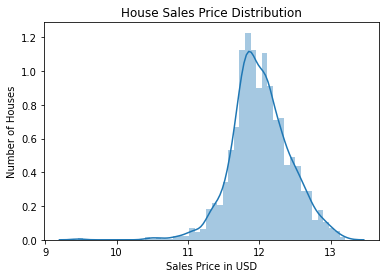

In [21]:
sns.distplot(target)
plt.xlabel("Sales Price in USD")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution")

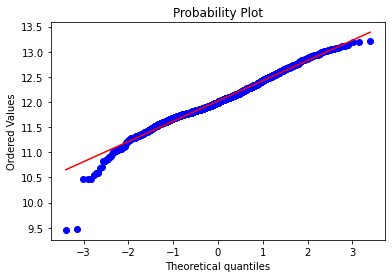

In [22]:
#QQ plot after log scale
from scipy import stats
fig = plt.figure()
res = stats.probplot(target, plot=plt)
plt.show()

# Create numerical columns and cleaning data


In [23]:
#find the numerical column in df_train by datatype
df_train.select_dtypes(include=['float64', 'int64']).columns

Index(['Id', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Mo Sold', 'Yr Sold',
       'SalePrice'],
      dtype='object')

In [24]:
#find the numerical column in df_test by datatype
df_test.select_dtypes(include=['float64', 'int64']).columns

Index(['Id', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Mo Sold', 'Yr Sold'],
      dtype='object')

In [25]:
#numeric columns in df_train  
#drop the columns 'ID', 'PID','Mo Sold', 'Yr Sold' as they are irrelevant and datetime.
#saleprice is target variable so will not be included in the feature selection
train_num_cols=df_train._get_numeric_data().drop(['Id','SalePrice'],axis=1)


In [26]:
train_num_cols.columns


Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Mo Sold', 'Yr Sold'],
      dtype='object')

In [27]:
#numeric columns in df_train  
#drop the columns 'ID', 'PID','Mo Sold', 'Yr Sold' as they are irrelevant and datetime.
#saleprice is target variable so will not be included in the feature selection
#make this a list to do for loop 
train_num_cols=list(df_train._get_numeric_data().drop(['Id','SalePrice'],axis=1))



In [28]:
#numeric columns in df_test, no SalePrice in df_test 
test_num_cols= list(df_test._get_numeric_data().drop(['Id'],axis=1))


In [29]:
#cleaning NaN
for fea in train_num_cols:
    df_train[fea]= df_train[fea].fillna(0.0)
    df_test[fea]=df_test[fea].fillna(0.0)

In [30]:
#30 numerical features in df_train
len(train_num_cols)

33

In [31]:
#30 numerical features in df_test
len(test_num_cols)

33

In [32]:
#keep track of train and test are having the same columns 
df_train[train_num_cols].head()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Mo Sold,Yr Sold
0,60,69.0552,13517,6,8,1976,2005,289.0,533.0,0.0,...,1976.0,2.0,475.0,0,44,0,0,0,3,2010
1,60,43.0000,11492,7,5,1996,1997,132.0,637.0,0.0,...,1997.0,2.0,559.0,0,74,0,0,0,4,2009
2,20,68.0000,7922,5,7,1953,2007,0.0,731.0,0.0,...,1953.0,1.0,246.0,0,52,0,0,0,1,2010
3,60,73.0000,9802,5,5,2006,2007,0.0,0.0,0.0,...,2007.0,2.0,400.0,100,0,0,0,0,4,2010
4,50,82.0000,14235,6,8,1900,1993,0.0,0.0,0.0,...,1957.0,2.0,484.0,0,59,0,0,0,3,2010


In [33]:
df_test[test_num_cols].head()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Mo Sold,Yr Sold
0,190,69.000000,9142,6,8,1910,1950,0.0,0.0,0.0,...,1910.0,1.0,440.0,0,60,112,0,0,4,2006
1,90,69.630042,9662,5,4,1977,1977,0.0,0.0,0.0,...,1977.0,2.0,580.0,170,0,0,0,0,8,2006
2,60,58.000000,17104,7,5,2006,2006,0.0,554.0,0.0,...,2006.0,2.0,426.0,100,24,0,0,0,9,2006
3,30,60.000000,8520,5,6,1923,2006,0.0,0.0,0.0,...,1935.0,2.0,480.0,0,0,184,0,0,7,2007
4,20,69.630042,9500,6,5,1963,1963,247.0,609.0,0.0,...,1963.0,2.0,514.0,0,76,0,0,185,7,2009


In [34]:
df_train['SalePrice'].head()

0    130500
1    220000
2    109000
3    174000
4    138500
Name: SalePrice, dtype: int64

# Create categorical columns and cleaning data

In [35]:
#categorical columns in df_train
cat_cols = df_train.select_dtypes(include=['object']).columns


In [36]:
#making a list of the categorical cols to for loop 
train_cat_cols =  list(df_train.select_dtypes(include=['object']).columns)

In [37]:
#categorical columnsin df_test
test_cat_cols =  list(df_test.select_dtypes(include=['object']).columns)

In [38]:
#some null value is not missing value but doesn't have that facilities in the house. 
#For instance, Fill NA in 'garage_qual'represent that the house doesn't not have a garage.
for col in train_cat_cols:
    df_train[col] = df_train[col].fillna(value='na')
    df_test[col] = df_test[col].fillna(value='na')

In [39]:
#38 categorical features in df_train
len(train_cat_cols)

37

In [40]:
#38 categorical features in df_test
len(test_cat_cols)

37

In [41]:
df_train[train_cat_cols].head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Central Air,Electrical,Kitchen Qual,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type
0,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,...,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD
1,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,...,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD
2,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD
3,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,...,Y,SBrkr,TA,Typ,BuiltIn,Fin,TA,TA,Y,WD
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,...,Y,SBrkr,TA,Typ,Detchd,Unf,TA,TA,N,WD


In [42]:
df_test[test_cat_cols].head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Central Air,Electrical,Kitchen Qual,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type
0,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,...,N,FuseP,Fa,Typ,Detchd,Unf,Po,Po,Y,WD
1,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,...,Y,SBrkr,TA,Typ,Attchd,Fin,TA,TA,Y,WD
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,New
3,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,...,Y,SBrkr,TA,Typ,Detchd,Unf,Fa,TA,N,WD
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD


In [43]:
#Final check for all missing data 
null_cols = df_train.isnull().sum()
mask_null = null_cols > 0
null_cols[mask_null].sort_values(ascending=False)


Series([], dtype: int64)

In [ ]:
null_cols = df_test.isnull().sum()
mask_null = null_cols > 0
null_cols[mask_null].sort_values(ascending=False)


# Encode or Map Categorical data

In [44]:
#For ordinal quality grading in df_train, 
#replace the ordinal value with num in df_train and df_test


quality_cols = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual',
                'Garage Qual','Garage Cond']
            
for col in quality_cols:
    df_train[col].replace({'Ex' : 5,'Gd' : 4,'TA' : 3,'Fa' : 2, 'Po' : 1,'na' : 0 },inplace=True)
    df_test[col].replace({'Ex' : 5,'Gd' : 4,'TA' : 3,'Fa' : 2, 'Po' : 1,'na' : 0 },inplace=True)
    
    #print(col)
    #print(df_train[col])

In [46]:
#replace the ordinal value with num in df_train
df_train.replace({'Land Slope': {'Gtl':3, 'Mod':2, 'Sev':1, 'na':0}} ,inplace=True) 

#replace the ordinal value with num in df_test
df_test.replace({'Land Slope': {'Gtl':3, 'Mod':2, 'Sev':1, 'na':0}} ,inplace=True)

In [47]:
#replace the ordinal value with num in df_train
df_train.replace({'Bsmt Exposure' : {'Gd':4,'Av':3,'Mn':2,'No':1,'na':0 }},inplace=True)

#replace the ordinal value with num in df_test
df_test.replace({'Bsmt Exposure' : {'Gd':4,'Av':3,'Mn':2,'No':1,'na':0 }},inplace=True)

In [48]:
#replace the ordinal value with num in df_train
df_train.replace({'Garage Finish' : {'Fin':3,'RFn': 2, 'Unf': 1,'na':0 }},inplace=True)

#replace the ordinal value with num in df_test
df_test.replace({'Garage Finish' : {'Fin':3,'RFn': 2, 'Unf': 1,'na':0 }},inplace=True)

In [49]:
#replace the ordinal value with num in df_train
df_train.replace({'Central Air' : {'Y':1,'N':0 }},inplace=True)

#replace the ordinal value with num in df_train
df_test.replace({'Central Air' : {'Y':1,'N':0 }},inplace=True)

In [50]:
#Keep track the shape of train and test 
df_train.shape

(2042, 72)

In [51]:
df_test.shape

(879, 71)

In [52]:
#ensure the columns are in correct data type, change Continuous value to float
int_to_float = ['Gr Liv Area','Wood Deck SF' ,'Open Porch SF' ,'Enclosed Porch','3Ssn Porch','Screen Porch','1st Flr SF',      
'2nd Flr SF','Low Qual Fin SF' ]
for cols in int_to_float:
    df_train[cols]=df_train[cols].astype(float)
    df_test[cols]=df_test[cols].astype(float)


In [53]:
#ensure the columns are in correct data type, change discrete value to int
float_to_int = ['Bsmt Full Bath','Bsmt Half Bath','Garage Yr Blt','Garage Cars']
for c in float_to_int:
    df_train[c]=df_train[c].astype(int)
    df_test[c]=df_test[c].astype(int)


In [54]:
#convert ordinal categorical cols into int 
#we can order the ordinal columns with ranking, yet the spacing between the values may not be the same across the levels of the variables.
#some of the columns has na value (which mean that the facilities is not present in the house. 

ordinal_cols = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual',
                'Garage Qual','Garage Cond','Land Slope','Bsmt Exposure','Garage Finish','Central Air']

for co in ordinal_cols:
    df_train[co]=df_train[co].astype(int)
    df_test[co]=df_test[co].astype(int)

In [55]:
#convert nominal categorical cols into string

nominal_cols = list(set(train_cat_cols) -set(ordinal_cols))
print(nominal_cols)


['Neighborhood', 'Roof Style', 'Electrical', 'BsmtFin Type 2', 'Condition 1', 'Sale Type', 'Street', 'Land Contour', 'Mas Vnr Type', 'Foundation', 'BsmtFin Type 1', 'Heating', 'Roof Matl', 'Utilities', 'MS Zoning', 'Condition 2', 'Bldg Type', 'House Style', 'Exterior 1st', 'Functional', 'Garage Type', 'Paved Drive', 'Lot Config', 'Exterior 2nd', 'Lot Shape']


In [56]:
for co in nominal_cols:
    df_train[co]=df_train[co].astype(str)
    df_test[co]=df_test[co].astype(str)

In [57]:
#Final check for all missing data 
null_cols = df_train.isnull().sum()
mask_null = null_cols > 0
null_cols[mask_null].sort_values(ascending=False)


Series([], dtype: int64)

In [58]:
#Final check for all missing data 
null_cols = df_test.isnull().sum()
mask_null = null_cols > 0
null_cols[mask_null].sort_values(ascending=False)


Series([], dtype: int64)

# First Summary after data cleaning

- now we have 33 numerical columns and 37 categorical columns in train and test.  

In [59]:
len(train_num_cols)

33

In [60]:
len(test_num_cols)

33

In [61]:
len(train_cat_cols)

37

In [62]:
len(test_cat_cols)

37

# Data Visualization

# EDA of numerical columns: look at the distribution

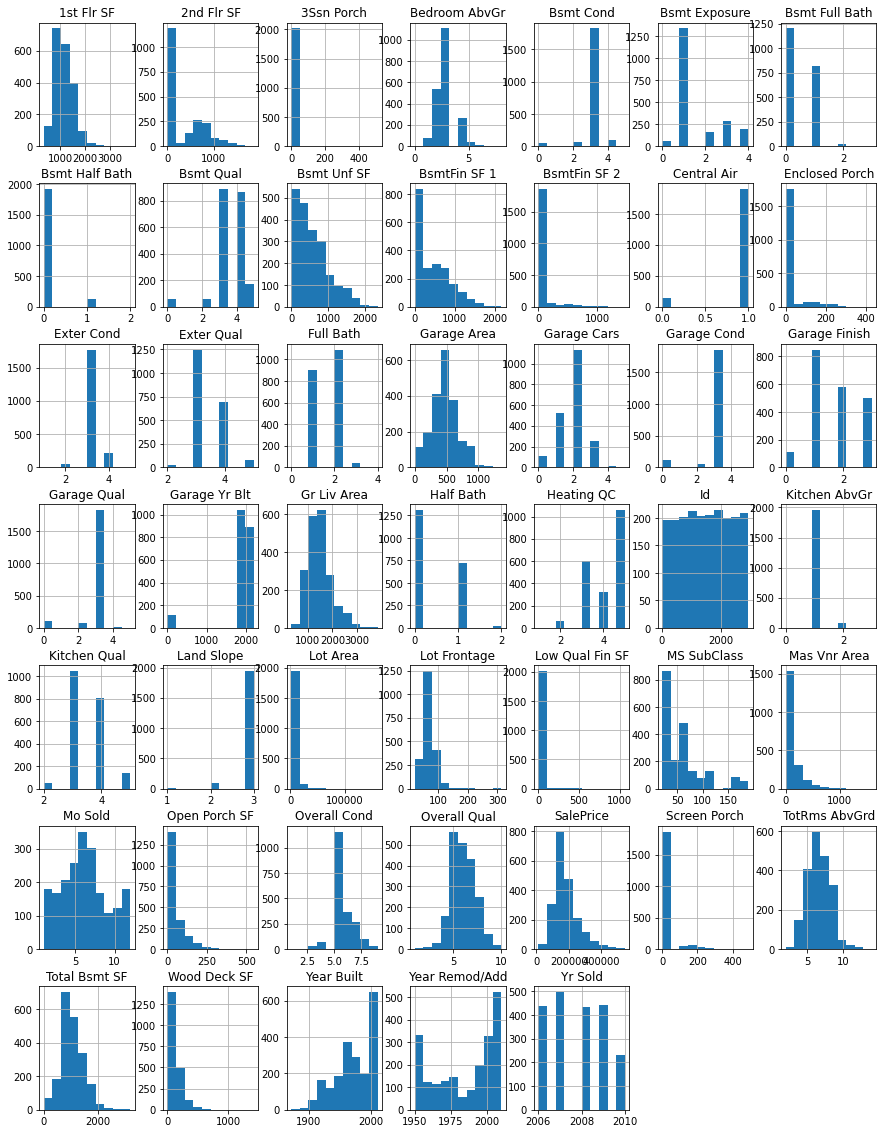

In [63]:
#plot historgram to get a sense of what are the range of each of the values
df_train.hist(figsize=(15, 20));


My obervation:
1.When was it build and when was it sold
- the distribution of mo sold (month sold the house) are concentrate on May to Aug.But the yr sold (year sold) seems do not have an obvious trend

2.Based on the distribution of Year Built and Year Remod, most of the houses are relatively new. Built after 2000

3.The house 's Area and what's inside :
- how big is the house ?
- how many bedroom , kitchen, bathroom?
- does the house has garage, basement?


4.The difference bewtween overall condition and overall quality. We do not know how the conditon and quality were rated. The rating could be subjective. will see how would these 2 ranking correlate to the sale price.
    

## EDA :  When to sold and - Investigate Yr Sold, Mo Sold 

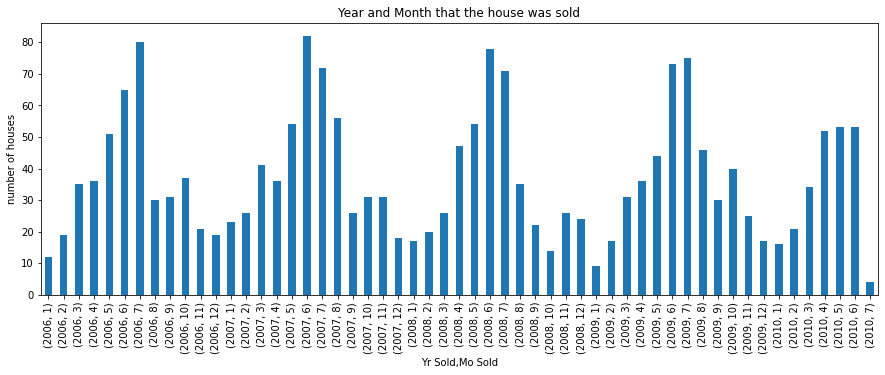

In [64]:
#from the historgram above, we can see that the distribution of mo sold (month sold the house) are concentrate on May to Aug.
#but the yr sold (year sold) seems do not have an obvious trend
#Every May and June from 2006-2009 is the peak season of properties selling 

df_train.groupby(['Yr Sold','Mo Sold']).Id.count().plot(kind='bar',figsize=(15,5))
plt.title ('Year and Month that the house was sold')
plt.ylabel ('number of houses')
plt.show()

## EDA :  When to build - InvestigateYear built, Year Remod/Add, GAr

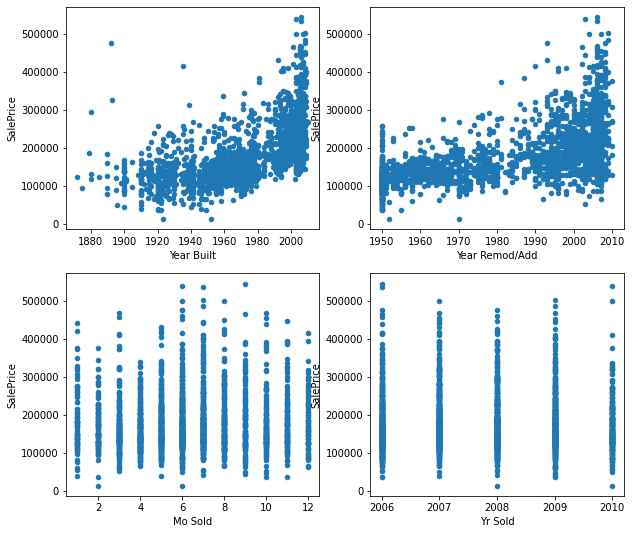

In [65]:
fig = plt.figure(2, figsize=(10,9))
ax1 = fig.add_subplot(2, 2, 1)
df_train.plot.scatter(x = 'Year Built', y = 'SalePrice', ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
df_train.plot.scatter(x = 'Year Remod/Add', y = 'SalePrice', ax=ax2)

ax3 = fig.add_subplot(2, 2, 3)
df_train.plot.scatter(x = 'Mo Sold', y = 'SalePrice', ax=ax3)

ax4 = fig.add_subplot(2, 2, 4)
df_train.plot.scatter(x = 'Yr Sold',y ='SalePrice', ax=ax4)

plt.show()

My obervation:
It seems that the Year build has corrrelation with sale price. 
I will ignore year sold and month sold for now. But bear in mind that Jun and Jul are the peak season of selling properties.


## EDA : What's inside(space) - Investigate area of house, garage, basement 

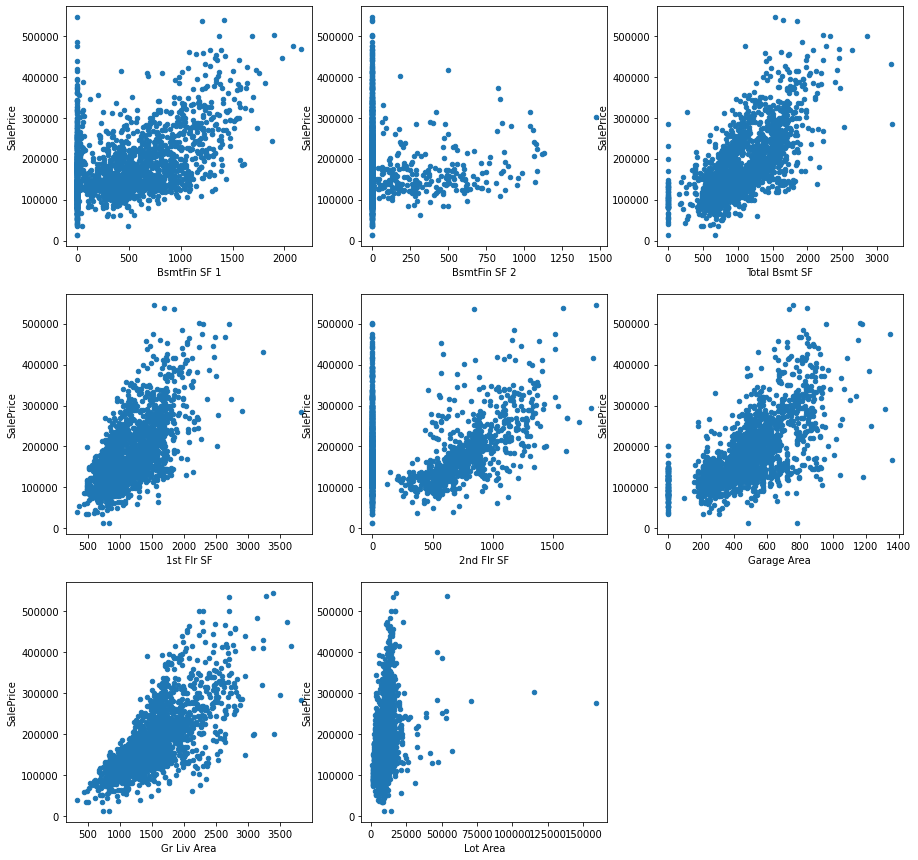

In [66]:
fig = plt.figure(2, figsize=(15,15))
ax1 = fig.add_subplot(3, 3, 1)
df_train.plot.scatter(x = 'BsmtFin SF 1', y = 'SalePrice', ax=ax1)

ax2 = fig.add_subplot(3, 3, 2)
df_train.plot.scatter(x = 'BsmtFin SF 2', y = 'SalePrice', ax=ax2)

ax3 = fig.add_subplot(3, 3, 3)
df_train.plot.scatter(x = 'Total Bsmt SF', y = 'SalePrice', ax=ax3)

ax4 = fig.add_subplot(3, 3, 4)
df_train.plot.scatter(x = '1st Flr SF',y ='SalePrice', ax=ax4)

ax5 = fig.add_subplot(3, 3, 5)
df_train.plot.scatter(x = '2nd Flr SF', y = 'SalePrice', ax=ax5)

ax6 = fig.add_subplot(3, 3, 6)
df_train.plot.scatter(x = 'Garage Area',y ='SalePrice', ax=ax6)

ax7 = fig.add_subplot(3, 3, 7)
df_train.plot.scatter(x = 'Gr Liv Area',y ='SalePrice', ax=ax7)  

ax8 = fig.add_subplot(3, 3, 8)
df_train.plot.scatter(x = 'Lot Area',y ='SalePrice', ax=ax8) 

plt.show()

My observation:
Overall the areas,except Lot Area,has positive impact on sale prices. Will run heatmap to have a closer look of the correlation later on.



## EDA : What's inside(space) - Investigate number of rooms  

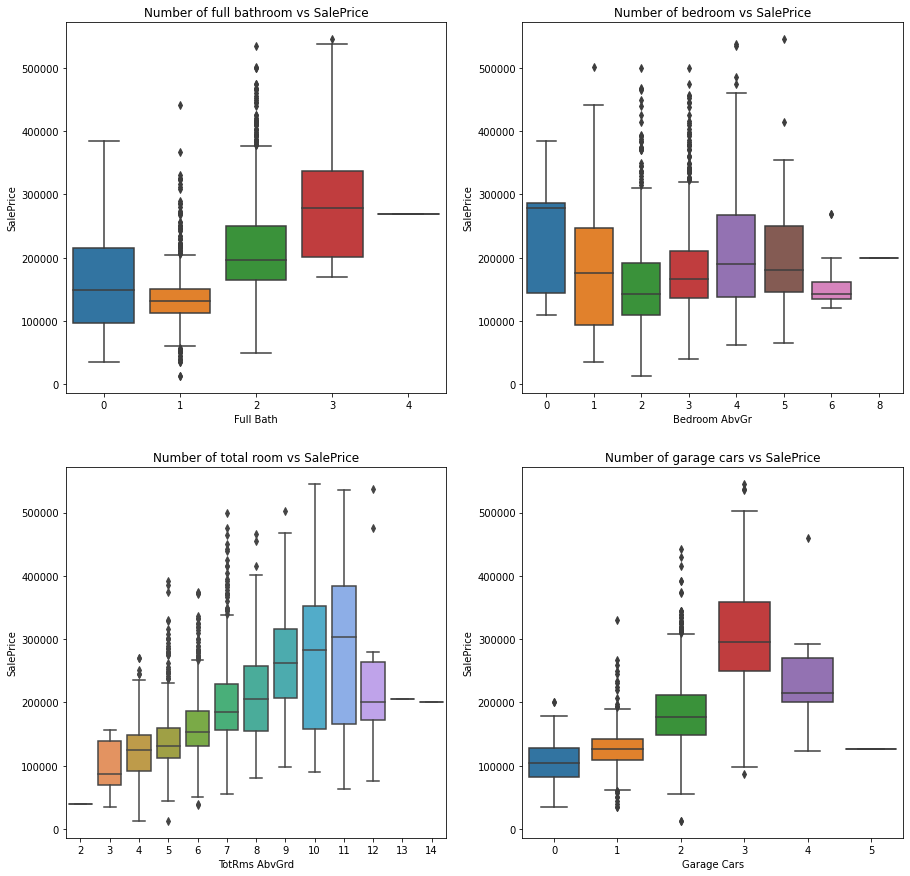

In [67]:
fig = plt.figure(2, figsize=(15,15))
ax1 = fig.add_subplot(2, 2, 1)
sns.boxplot(y='SalePrice', x='Full Bath', data=df_train, ax=ax1)
plt.title('Number of full bathroom vs SalePrice')

ax2 = fig.add_subplot(2, 2, 2)
sns.boxplot(y='SalePrice', x='Bedroom AbvGr', data=df_train, ax=ax2)
plt.title('Number of bedroom vs SalePrice')

ax3 = fig.add_subplot(2, 2, 3)
sns.boxplot(y='SalePrice', x='TotRms AbvGrd', data=df_train, ax=ax3)
plt.title('Number of total room vs SalePrice')

ax4 = fig.add_subplot(2, 2, 4)
sns.boxplot(y='SalePrice', x='Garage Cars', data=df_train, ax=ax4)
plt.title('Number of garage cars vs SalePrice')


plt.show()

My observation:
- the number of bathroom, total rooms and the garage cars has positive impact on the sale price. 
- bedroom has less variance.
- once the total rooms is more than 11 rooms, the price will drop

## EDA :  Where are they (location) - Investigate  Neighbourhood

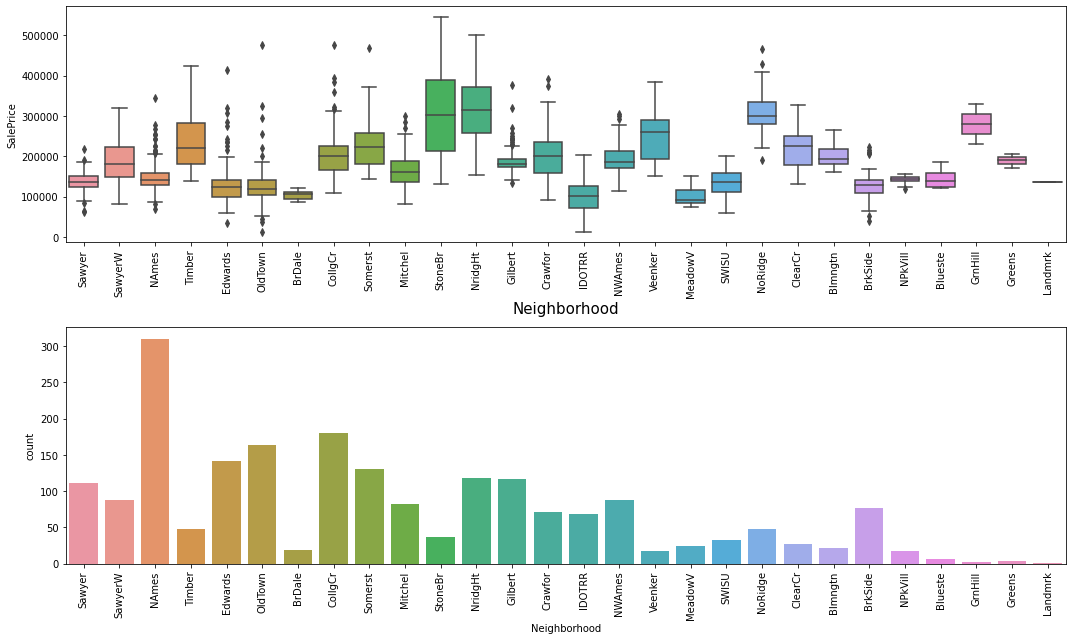

In [68]:
#'Neighborhood' box plot and count plot
# Plotting neighborhoods to get a sense of how they compare to sale price.

fig = plt.figure(2, figsize=(15,9))
ax1 = fig.add_subplot(2, 1, 1)
#fig = plt.figure(figsize = (15, 8))
sns.boxplot(x = 'Neighborhood', y = 'SalePrice',  data = df_train)
xt = plt.xticks(rotation=90)
fig.savefig('df_train', bbox_inches='tight')
ax1.set_xlabel('Neighborhood',fontsize=15)

ax2 = fig.add_subplot(2, 1, 2)
#ig = plt.figure(figsize = (12, 6))
sns.countplot(x = 'Neighborhood', data = df_train)
xt = plt.xticks(rotation=90)
fig.savefig('df_train', bbox_inches='tight')

plt.tight_layout()
plt.show()

My observation:
- Stone Brook (StoneBr) ,Northridge Heights(NridgHt),Northridge(NoRidge) have the highest sale prices
- North Ames (NAmes) has most supplies of properties and sale price is relatively low
- College creek (CollgCr) has second most supplies of properties but the sale price is in the middle range. (not too low and not too high)


## EDA : What is the rating (buliding quality) - Investigate overall condition and overall quality

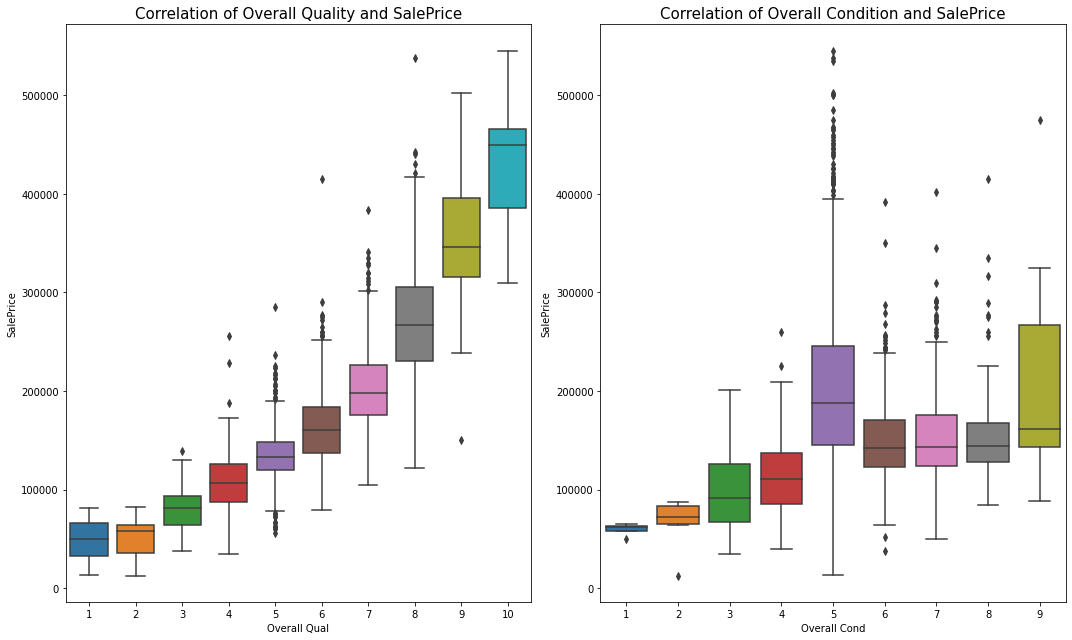

In [69]:
fig = plt.figure(2, figsize=(15,9))
ax1 = fig.add_subplot(1, 2, 1)
sns.boxplot(df_train['Overall Qual'], df_train['SalePrice']) 
plt.title('Correlation of Overall Quality and SalePrice',fontsize=15)

ax2 = fig.add_subplot(1, 2, 2)
#f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Overall Cond', y="SalePrice", data=df_train)
plt.title('Correlation of Overall Condition and SalePrice',fontsize=15)

plt.tight_layout()
plt.show()

My observation:
It is really weird on overall condition rate 5 (Average)
Overall Quality makes sense , the higher quality has the higher saleprice 


In [70]:
#deep dive into overall condition rate 5 
#I am wondering if it is related to location 
weird_cond = df_train.loc[df_train['Overall Cond']==5,'Neighborhood']

In [71]:
weird_cond.value_counts().head()

CollgCr    155
Somerst    127
NridgHt    118
NAmes      117
Gilbert    108
Name: Neighborhood, dtype: int64

In [72]:
df_train['SalePrice'].head()

0    130500
1    220000
2    109000
3    174000
4    138500
Name: SalePrice, dtype: int64

In [73]:
df_train['Neighborhood'].value_counts().head()

NAmes      310
CollgCr    180
OldTown    163
Edwards    141
Somerst    130
Name: Neighborhood, dtype: int64

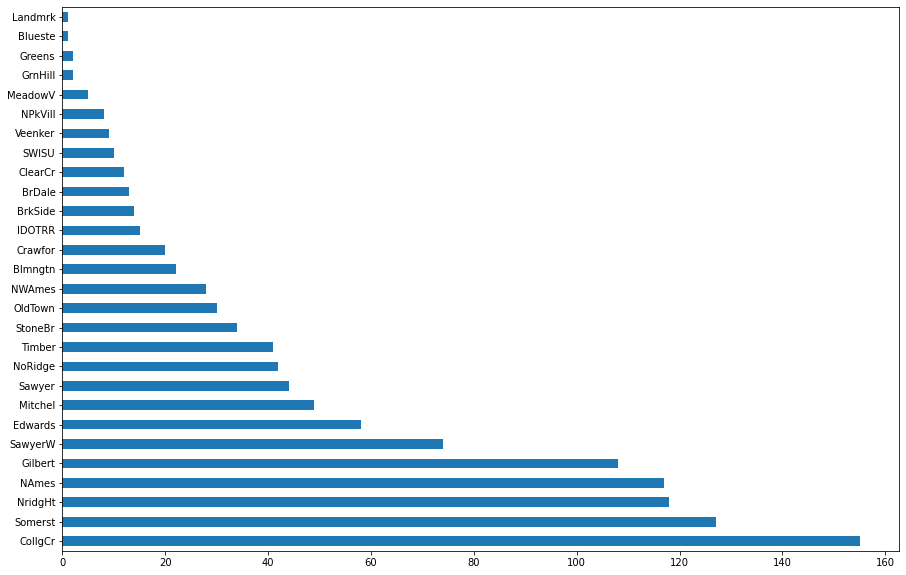

In [74]:
weird_cond.value_counts().plot(kind='barh',figsize=(15,10))

My observation:
Based on the bar plot above, we can see that most of the overall condition rate 5 houses are in CollgCr(College Creek) 155 out of 180 houses in College Creek are in rate 5.

After doing outside research, the location of College Creek is near Lowa State University. The housing market might have demand by students. 

Wil run corelation to determine if Overall condition is a useful feature.

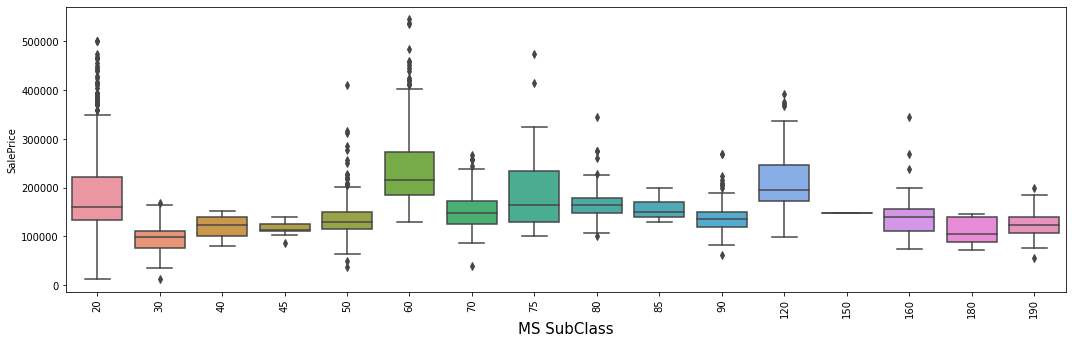

In [75]:
fig = plt.figure(2, figsize=(15,9))
ax1 = fig.add_subplot(2, 1, 1)
#fig = plt.figure(figsize = (15, 8))
sns.boxplot(x = 'MS SubClass', y = 'SalePrice',  data = df_train)
xt = plt.xticks(rotation=90)
fig.savefig('df_train', bbox_inches='tight')
ax1.set_xlabel('MS SubClass',fontsize=15)

plt.tight_layout()
plt.show()

My observation:

MS sub class 20(020	1-STORY 1946 & NEWER ALL STYLES)and 60 (2-STORY 1946 & NEWER) are selling better. May use them for interaction term.
Other MS sub class has low variance. Overall the variance of MS subclass is low

In [76]:
df_train.shape

(2042, 72)

In [77]:
df_test.shape


(879, 71)

## EDA other categorical columns

In [78]:
df_train[train_cat_cols].columns

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Sale Type'],
      dtype='object')

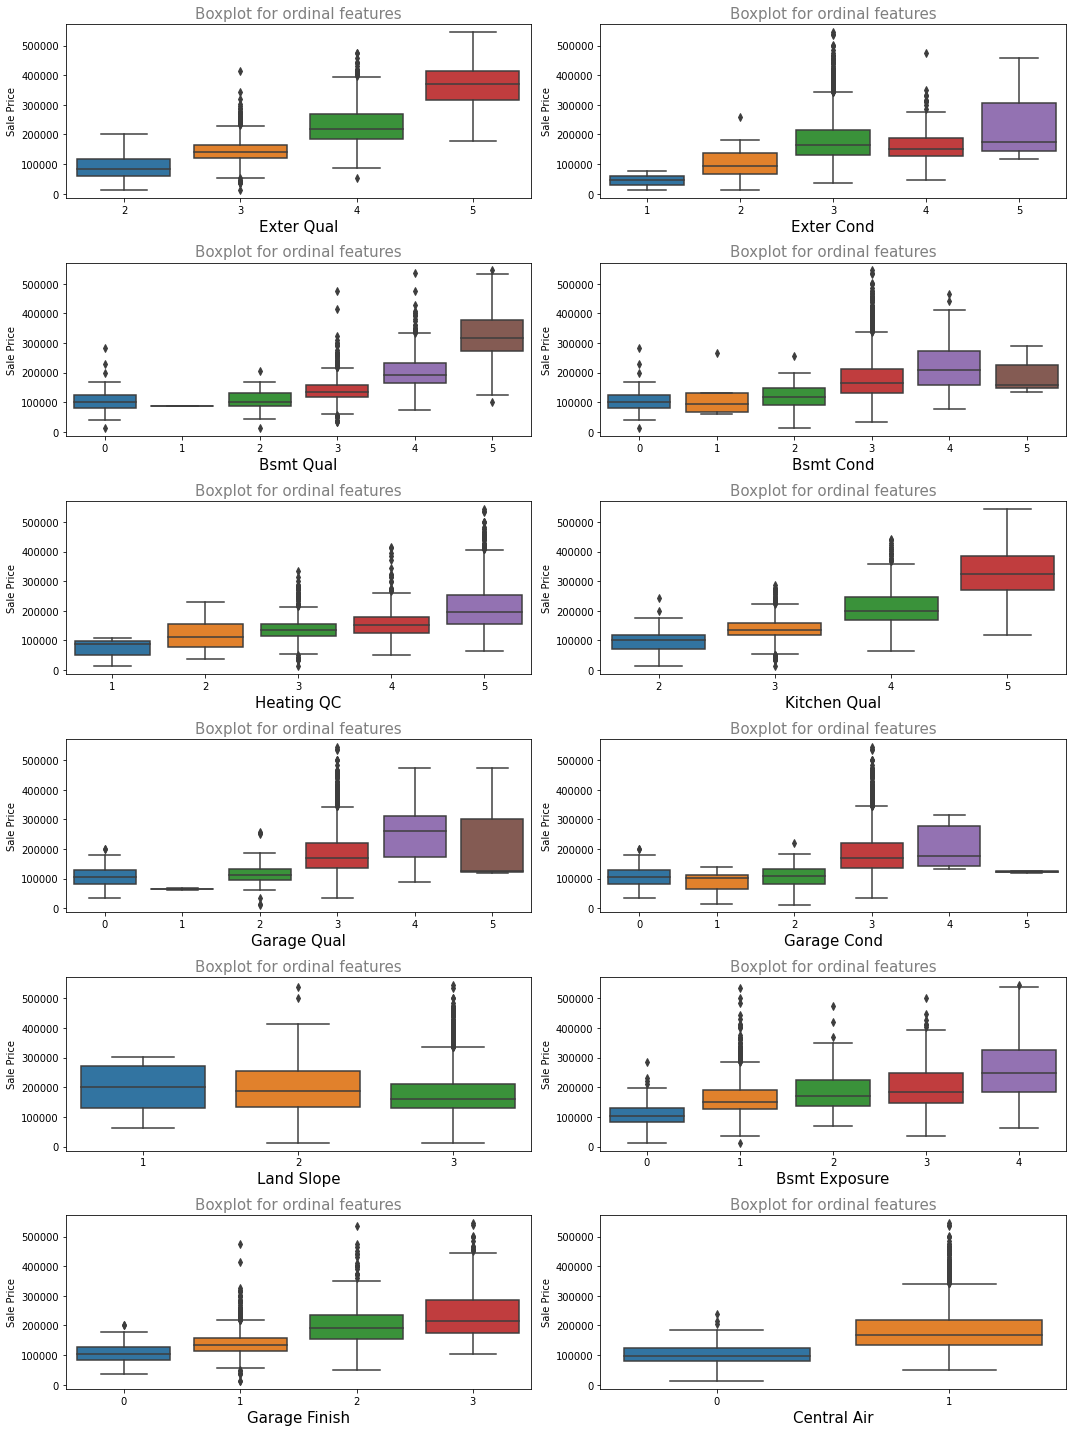

In [79]:
ordinal_cols = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual',
                'Garage Qual','Garage Cond','Land Slope','Bsmt Exposure','Garage Finish','Central Air']


fig,ax =plt.subplots(nrows=6,ncols=2,figsize=(15,20))
ax= ax.ravel()   


for i, column in enumerate(ordinal_cols[0:]): # Gives us an index value to get into all our lists
        sns.boxplot(x=column, y='SalePrice', data=df_train, orient= 'v', ax=ax[i]) 
        # Set titles, labels, etc here for each subplot
        ax[i].set_title('Boxplot for ordinal features',fontsize=15, fontweight=0, color='grey', loc='center')
        ax[i].set_xlabel(column, fontsize=15)
        ax[i].set_ylabel('Sale Price')

plt.tight_layout()
plt.show()

My observation :
There are some cols do not have high variance : 'Exter Cond','Garage Cond','Land Slope', 'Bsmt Exposure',' Bsmt Cond','Heating QC','Garage Finish'

features I will keep : 'Exter Qual','Bsmt Qual','Kitchen Qual','Garage Qual', 'Central Air' , 

It give me a sense that when a a varaible have Qual and Cond any parts of the house, the Qual varaibles have high variance. For example,'Exter Cond' and 'Exter Qual' , 'Bsmt Cond' and 'Bsmt Qual'

Total cols : 12 
drop cols : 7
I keep : 5 cols


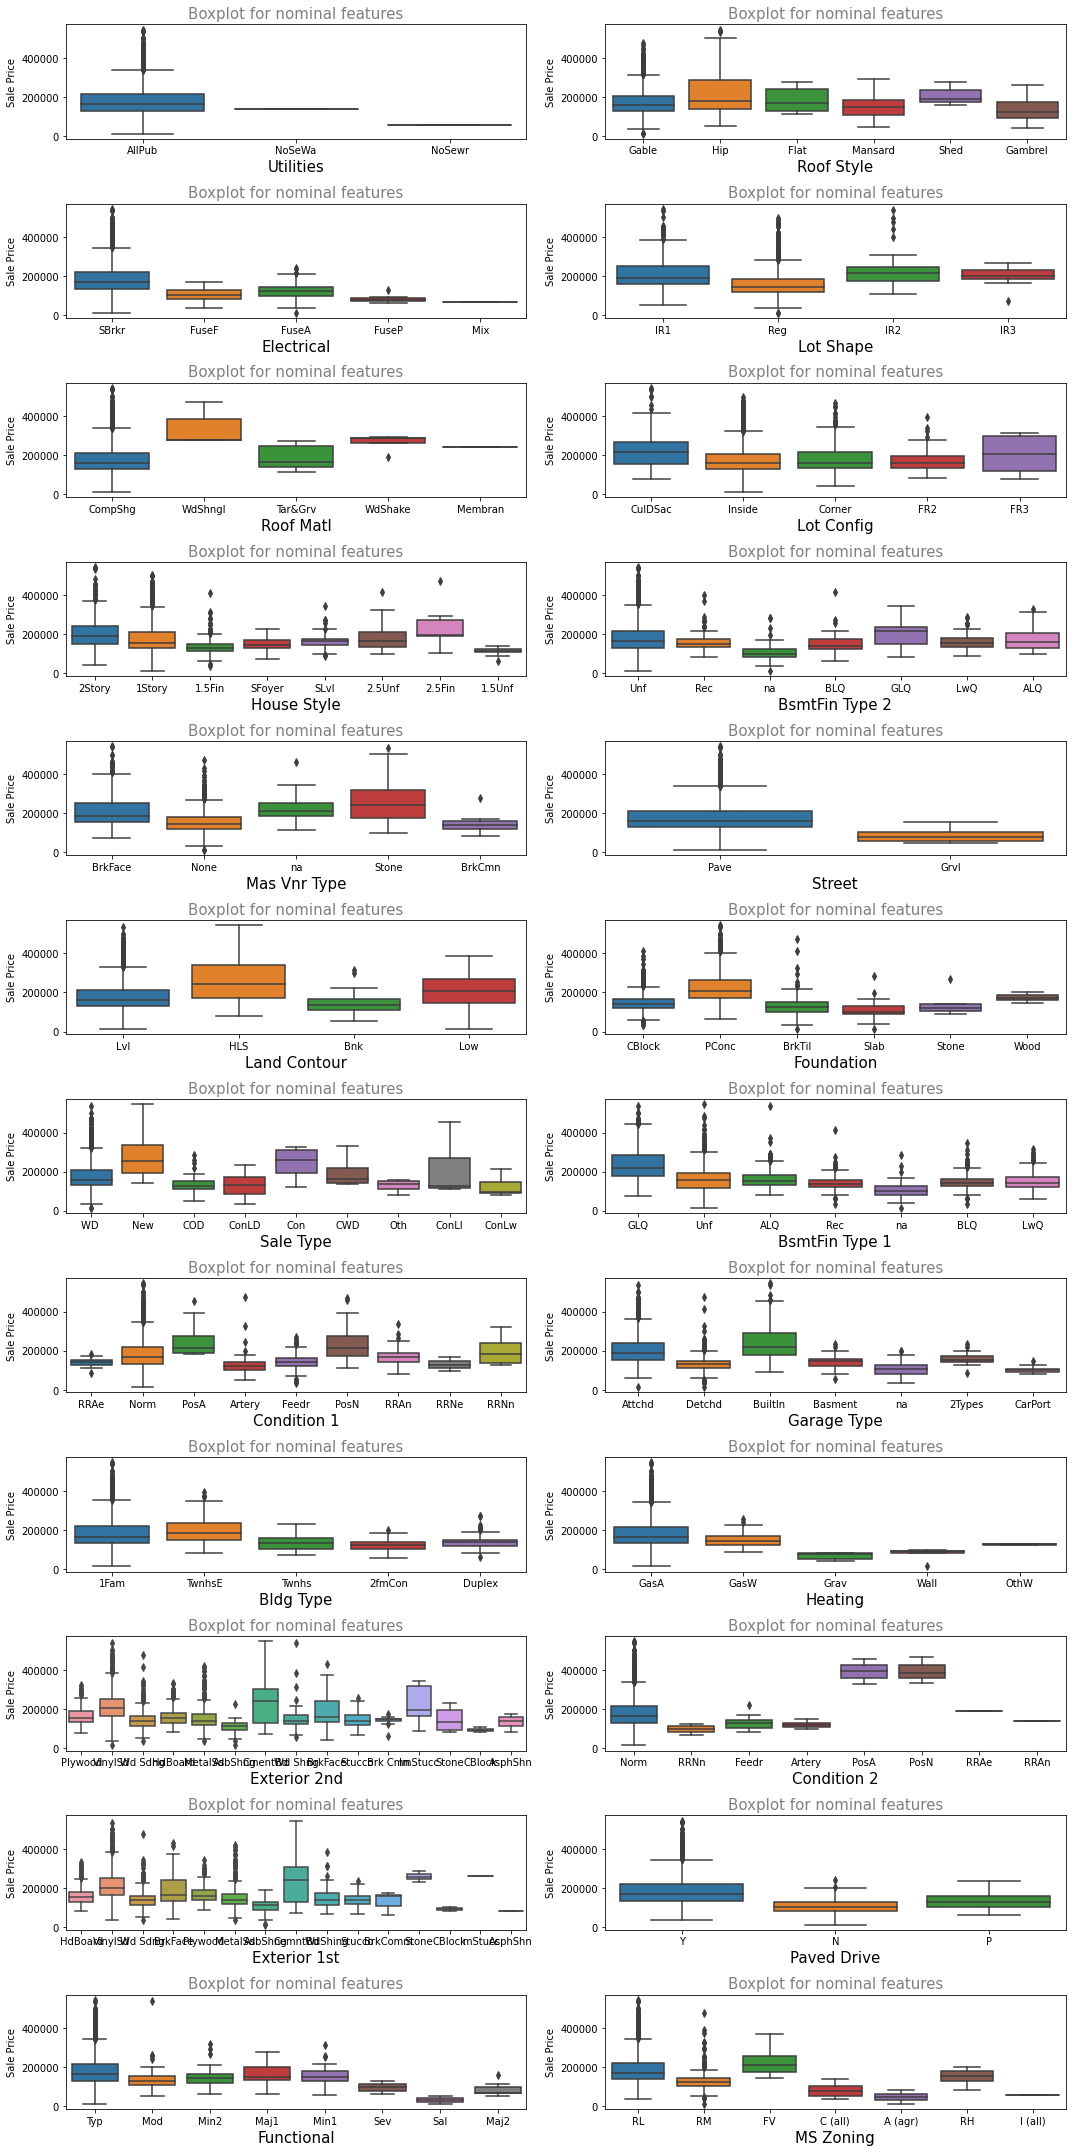

In [80]:
#check variance of nominal columns by box plots. except Neighbourhood and MS subclass 

nominal_cols =['Utilities', 'Roof Style', 'Electrical', 'Lot Shape', 'Roof Matl', 'Lot Config', 
               'House Style', 'BsmtFin Type 2', 'Mas Vnr Type', 'Street', 'Land Contour', 'Foundation', 
               'Sale Type', 'BsmtFin Type 1', 'Condition 1', 'Garage Type', 'Bldg Type', 'Heating', 
               'Exterior 2nd', 'Condition 2', 'Exterior 1st', 'Paved Drive', 'Functional', 'MS Zoning']

fig,ax =plt.subplots(nrows=12,ncols=2,figsize=(15,30))
ax= ax.ravel()   

for i, columns in enumerate(nominal_cols[0:]):  # Gives us an index value to get into all our lists
        sns.boxplot(x=columns, y='SalePrice', data=df_train, orient= 'v', ax=ax[i]) 
        # Set titles, labels, etc here for each subplot
        ax[i].set_title('Boxplot for nominal features',fontsize=15, fontweight=0, color='grey', loc='center')
        ax[i].set_xlabel(columns, fontsize=15)
        ax[i].set_ylabel('Sale Price')

plt.tight_layout()
plt.show()

My observation :
There are some cols do not have high variance or having a dominated value is in same catagory , for example in 'Utilities, the majority is AllPub. This is not neccessary adding value to the modeling. 

cols do not have high variance: : 'Utilities', 'Roof Style', 'Electrical','Lot Shape', 'Roof Mati, 'Lot Config','House Style','BsmtFin Type 2','Mas Vnr Type', 'Street','Foundation','BsmtFin Type 1', 'BsmtFin Type 2', 'Bldg Type', 'Heating', 'Paved Drive' ,'Functional','Sale Type'

Cols I will keep : 'MS Zonging', 'Exterior 1st' , 'Exterior 2nd', ' Conditional 2', 'Garage Type' ,'Land Contour'

Total cols: 24
Drop cols: 18
I keep : 6

## EDA : Spearman's Correlation with the sale price

Spearman's correlation determines the strength and direction of the monotonic relationship between your two variables. We use spearman for the correlation of ordinal columns and sale price 
Reference : Spearman's Rank-Order Correlation
,retrieved from https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php

In [81]:
#check the corealtion of ordinal cols and the sale price by using spearman corelation
#result similar to the decision made based on the box plot.
#will keep Bsmt Qual, Exter Qual, Kitchen Qual.
#keep an eye on Garage Finish as I planned to drop it based on the box plot.

df_train[ordinal_cols+ ['SalePrice']].corr('spearman')['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
Bsmt Qual        0.695820
Exter Qual       0.694578
Kitchen Qual     0.682151
Garage Finish    0.633506
Heating QC       0.516741
Bsmt Exposure    0.377800
Garage Qual      0.366918
Garage Cond      0.340812
Central Air      0.339654
Bsmt Cond        0.281157
Exter Cond       0.029487
Land Slope      -0.052058
Name: SalePrice, dtype: float64

## EDA : Pearson's Correlation with the sale price
Pearson's correlation determines the strength and direction of the linear relationship between two variables. 


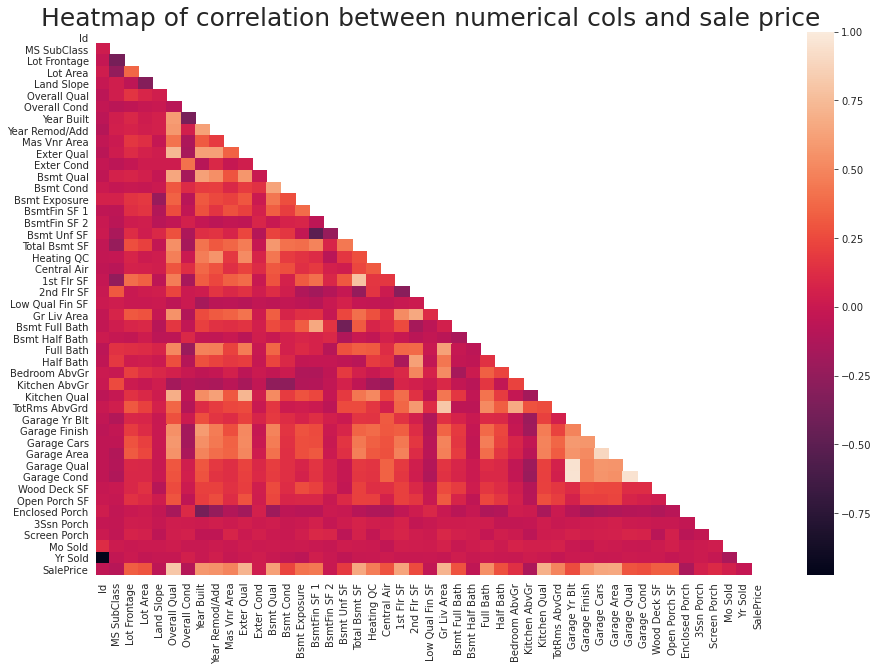

In [82]:
###  Plot a Heatmap of the Correlation Matrix
#Heatmaps are an effective way to visually examine the correlational structure of the predictors. 
#

plt.figure(figsize=(15,10))

mask = np.zeros_like(df_train.corr())
#mask 
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(df_train.corr(),mask=mask, annot=False)
    ax.set_title("Heatmap of correlation between numerical cols and sale price", fontsize=25);

In [83]:
#take a closer look 
#also check if there is any high negative coef
#drop low corelation columns : 
df_corr = df_train.corr()
print(df_corr.shape)
corr_sort= df_corr['SalePrice'].sort_values(ascending=False)
corr_sort

(47, 47)


SalePrice          1.000000
Overall Qual       0.807466
Gr Liv Area        0.716787
Exter Qual         0.714484
Kitchen Qual       0.695240
Total Bsmt SF      0.654788
Garage Area        0.654631
Garage Cars        0.652056
1st Flr SF         0.638401
Bsmt Qual          0.614195
Year Built         0.580150
Garage Finish      0.565834
Year Remod/Add     0.558832
Full Bath          0.538101
TotRms AbvGrd      0.495542
Mas Vnr Area       0.495266
Heating QC         0.464546
BsmtFin SF 1       0.444086
Bsmt Exposure      0.413726
Open Porch SF      0.334484
Lot Frontage       0.333593
Wood Deck SF       0.331889
Lot Area           0.292429
Garage Qual        0.290008
Bsmt Full Bath     0.287885
Central Air        0.285251
Half Bath          0.279347
Garage Cond        0.272446
Garage Yr Blt      0.265177
2nd Flr SF         0.253745
Bsmt Cond          0.233152
Bsmt Unf SF        0.187108
Bedroom AbvGr      0.137144
Screen Porch       0.107108
3Ssn Porch         0.052777
Mo Sold            0

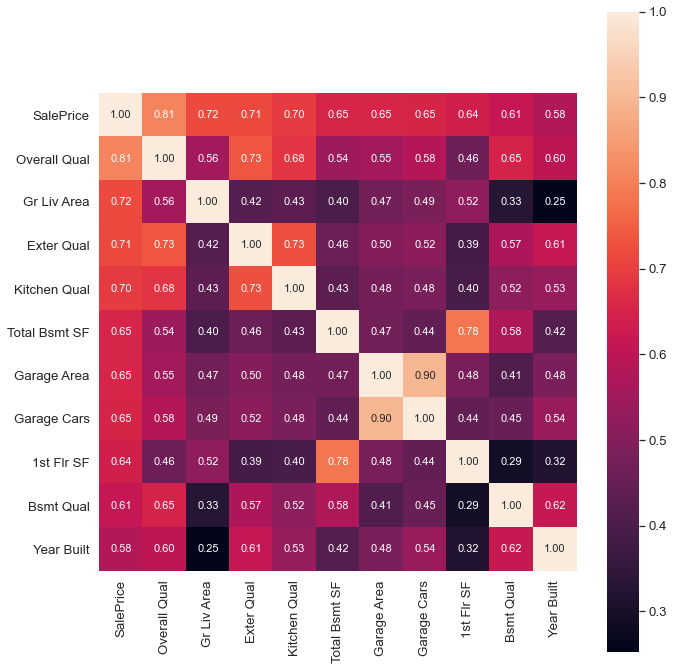

In [84]:
#find the 10 most high coef with SalePrice

plt.figure(figsize=(10,10))
cols = df_corr.nlargest(11, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.2)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=cols.values, xticklabels=cols.values)

plt.tight_layout()

plt.show()

In [85]:
cols 


Index(['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Exter Qual',
       'Kitchen Qual', 'Total Bsmt SF', 'Garage Area', 'Garage Cars',
       '1st Flr SF', 'Bsmt Qual', 'Year Built'],
      dtype='object')

### Check the existence of multicollinearity

In [86]:
# Look at the correlation between variables. 
# drop some multicollinearity variables 
#will have to drop 'Garage Area' , 'TotRms AbvGrd' ,'1st Flr SF' ,'TotRms AbvGrd','2nd Flr SF','Year Remod/Add','Full Bath'

df_corr = df_train[train_num_cols].corr()
df_corr.stack()[(df_corr.stack() > 0.6) & (df_corr.stack() < 1)].sort_values(ascending=False)

Garage Area     Garage Cars       0.897145
Garage Cars     Garage Area       0.897145
TotRms AbvGrd   Gr Liv Area       0.809073
Gr Liv Area     TotRms AbvGrd     0.809073
Total Bsmt SF   1st Flr SF        0.784575
1st Flr SF      Total Bsmt SF     0.784575
TotRms AbvGrd   Bedroom AbvGr     0.670419
Bedroom AbvGr   TotRms AbvGrd     0.670419
2nd Flr SF      Gr Liv Area       0.658673
Gr Liv Area     2nd Flr SF        0.658673
Bsmt Full Bath  BsmtFin SF 1      0.658459
BsmtFin SF 1    Bsmt Full Bath    0.658459
Year Remod/Add  Year Built        0.627149
Year Built      Year Remod/Add    0.627149
Gr Liv Area     Full Bath         0.625938
Full Bath       Gr Liv Area       0.625938
2nd Flr SF      Half Bath         0.616465
Half Bath       2nd Flr SF        0.616465
Year Built      Overall Qual      0.600476
Overall Qual    Year Built        0.600476
dtype: float64

In [87]:
#dropping cols based on the EDA 
drop_cols2 = ['Exter Cond', 'Heating QC', 'Garage Cond','Land Slope', 'Garage Finish', 'Bsmt Exposure','Bsmt Cond'
              ,'Utilities', 'Roof Style', 'Electrical','Lot Shape', 'Roof Matl', 'Lot Config','House Style','BsmtFin Type 2'
              ,'Mas Vnr Type', 'Street','Foundation','BsmtFin Type 1', 'BsmtFin Type 2', 'Bldg Type', 'Heating', 'Paved Drive' 
              ,'Functional','Sale Type','MS SubClass'
              ,'Yr Sold' , 'Mo Sold' , 'Lot Area','BsmtFin SF 1'
              ,'Garage Area' , 'TotRms AbvGrd' ,'1st Flr SF' ,'TotRms AbvGrd','2nd Flr SF','Year Remod/Add'
              ,'Full Bath','Mas Vnr Area', 'Open Porch SF' ,  'Lot Frontage' , 'Wood Deck SF' ,'Lot Area' ,'Garage Qual' 
              ,'Bsmt Full Bath' ,'Central Air','Half Bath' ,'Garage Cond' ,'Garage Yr Blt', 'Bsmt Unf SF' , 'Bedroom AbvGr' 
              ,'Screen Porch' ,'3Ssn Porch','BsmtFin SF 2' , 'Low Qual Fin SF','Bsmt Half Bath', 'Overall Cond' 
              ,'Kitchen AbvGr' ,'Enclosed Porch']
     


In [88]:
df_train = df_train.drop(drop_cols2, axis=1)


In [89]:
df_test = df_test.drop(drop_cols2, axis=1)

In [90]:
#We have 18 cols left
df_train.shape

(2042, 18)

In [91]:
df_test.shape

(879, 17)

## EDA : Pairplot of the High Correlation features

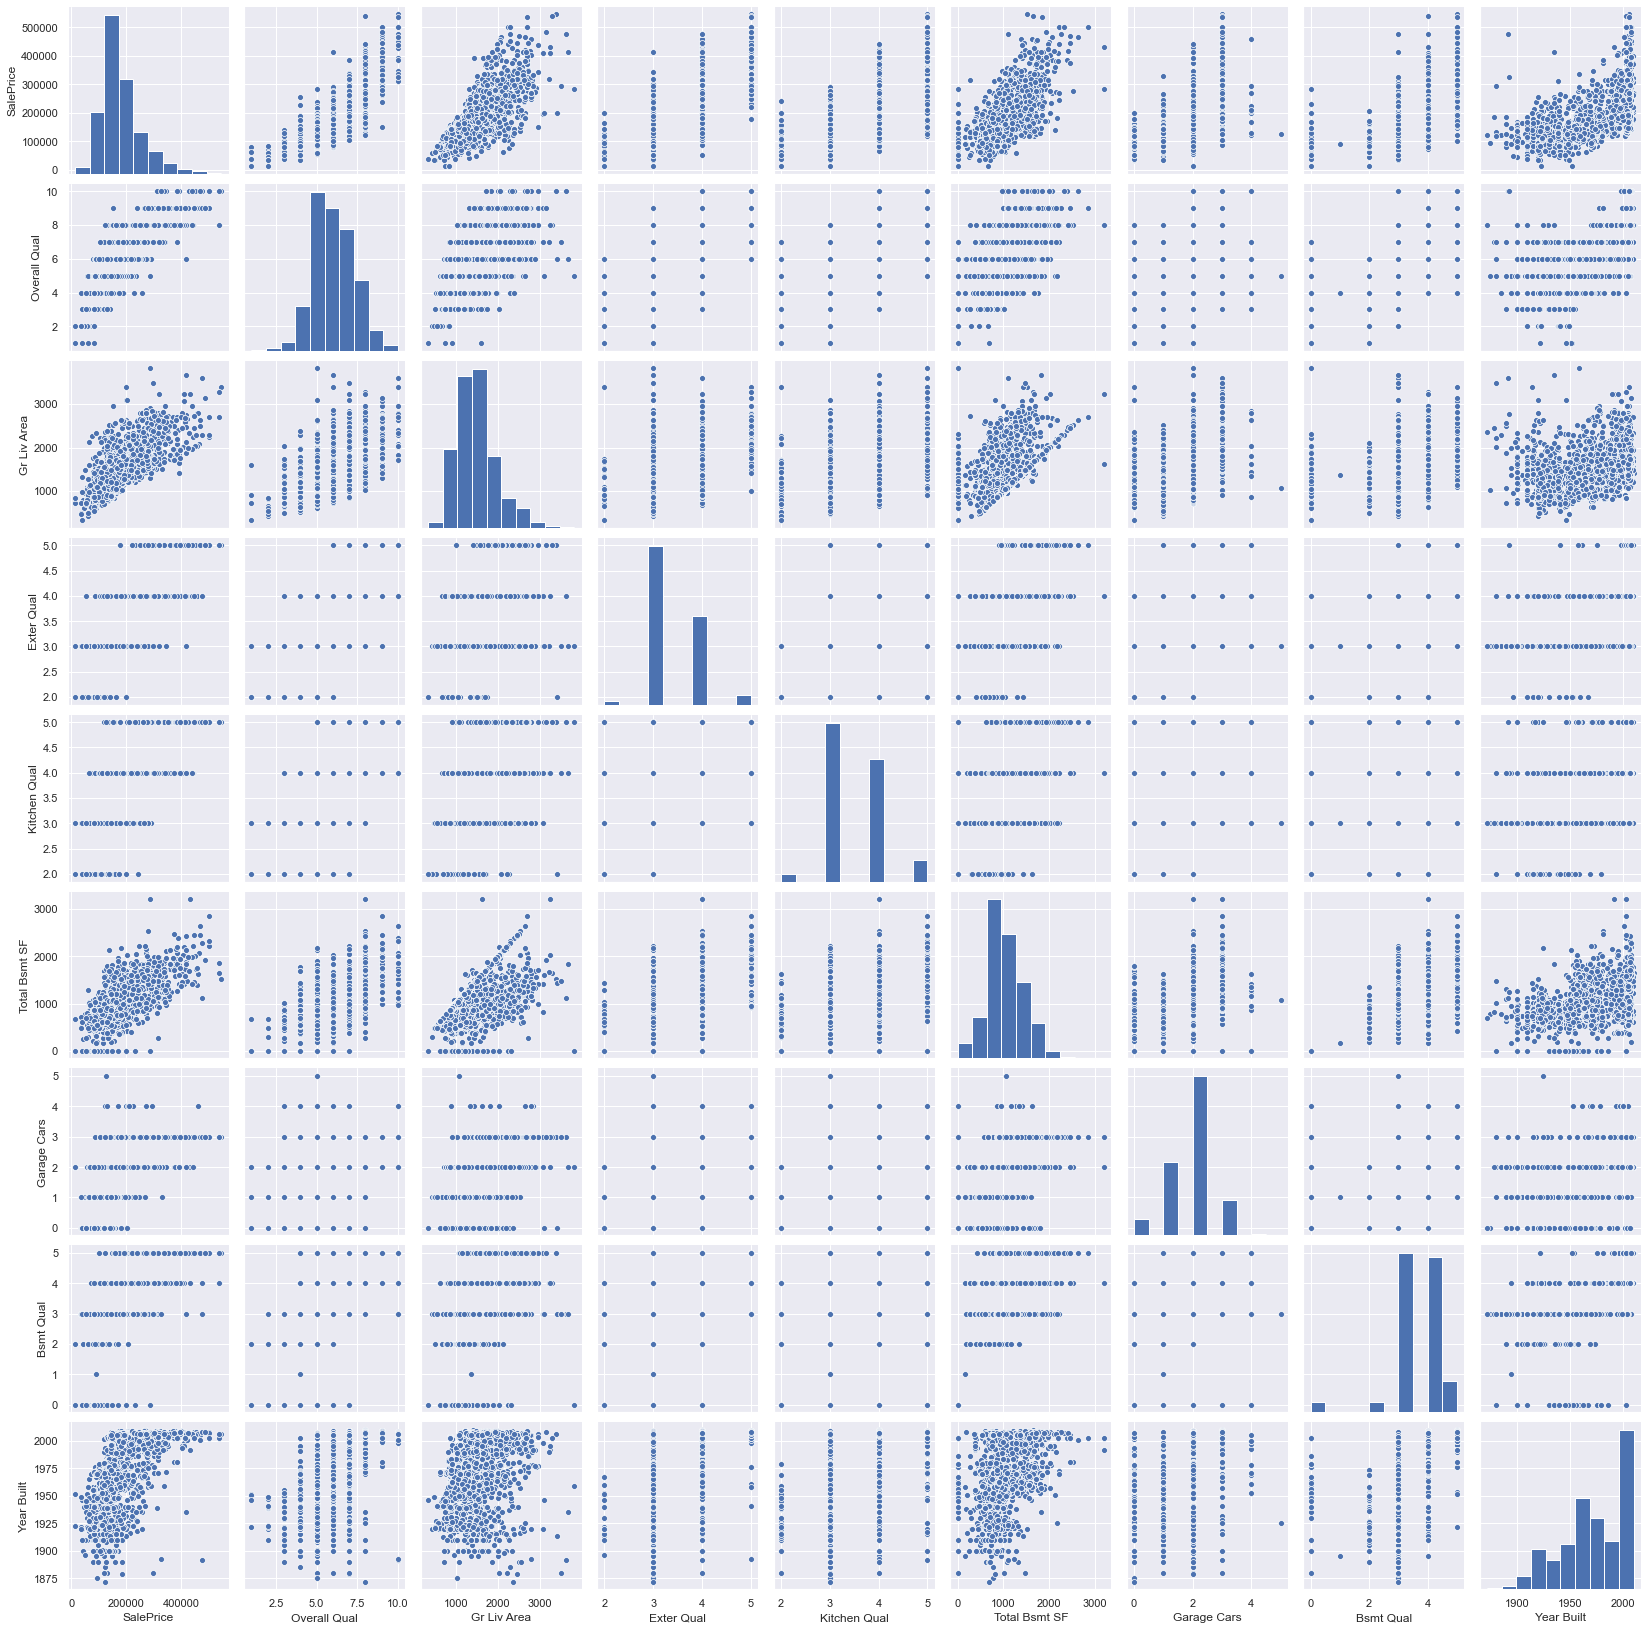

In [92]:
sns.set()
cols = ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Exter Qual','Kitchen Qual','Total Bsmt SF', 'Garage Cars', 'Bsmt Qual','Year Built',
        ]
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

## Features Engineering : New columns

Let's do some mix and match of the features. 

In [93]:
#create new columns to filter houses which are not older than 10 years
#newer building have higher saleprice 
#change boolen to integer
df_train['Young_age'] =  (df_train['Year Built'] > 2000).astype(int)

#(shd['sq__ft'] > 3775).astype(int)

In [94]:
df_test['Young_age'] = (df_test['Year Built'] > 2000).astype(int)


In [95]:
#create new columns with total house area in df_train and df_test 
df_train['total area'] = df_train['Total Bsmt SF']+ df_train['Gr Liv Area']

# drop from features to avoid collinearity with TotalSF
#features_num = [x for x in features_num if x not in ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF']]

In [96]:
#df_train['total_area'] = df_train['Total Bsmt SF']+ df_train['Gr Liv Area']
df_test['total area'] = df_test['Total Bsmt SF']+ df_test['Gr Liv Area']

In [97]:
#check missing value in train after adding new columns
df_train.isnull().sum()

Id               0
MS Zoning        0
Land Contour     0
Neighborhood     0
Condition 1      0
Condition 2      0
Overall Qual     0
Year Built       0
Exterior 1st     0
Exterior 2nd     0
Exter Qual       0
Bsmt Qual        0
Total Bsmt SF    0
Gr Liv Area      0
Kitchen Qual     0
Garage Type      0
Garage Cars      0
SalePrice        0
Young_age        0
total area       0
dtype: int64

In [98]:
#check missing value in test after adding new columns
df_test.isnull().sum()

Id               0
MS Zoning        0
Land Contour     0
Neighborhood     0
Condition 1      0
Condition 2      0
Overall Qual     0
Year Built       0
Exterior 1st     0
Exterior 2nd     0
Exter Qual       0
Bsmt Qual        0
Total Bsmt SF    0
Gr Liv Area      0
Kitchen Qual     0
Garage Type      0
Garage Cars      0
Young_age        0
total area       0
dtype: int64

In [99]:
df_train.isnull().sum().tail()

Garage Type    0
Garage Cars    0
SalePrice      0
Young_age      0
total area     0
dtype: int64

In [100]:
df_test.isnull().sum().tail()

Kitchen Qual    0
Garage Type     0
Garage Cars     0
Young_age       0
total area      0
dtype: int64

In [101]:
df_train['SalePrice'].head()

0    130500
1    220000
2    109000
3    174000
4    138500
Name: SalePrice, dtype: int64

In [102]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2042 entries, 0 to 2050
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2042 non-null   int64  
 1   MS Zoning      2042 non-null   object 
 2   Land Contour   2042 non-null   object 
 3   Neighborhood   2042 non-null   object 
 4   Condition 1    2042 non-null   object 
 5   Condition 2    2042 non-null   object 
 6   Overall Qual   2042 non-null   int64  
 7   Year Built     2042 non-null   int64  
 8   Exterior 1st   2042 non-null   object 
 9   Exterior 2nd   2042 non-null   object 
 10  Exter Qual     2042 non-null   int64  
 11  Bsmt Qual      2042 non-null   int64  
 12  Total Bsmt SF  2042 non-null   float64
 13  Gr Liv Area    2042 non-null   float64
 14  Kitchen Qual   2042 non-null   int64  
 15  Garage Type    2042 non-null   object 
 16  Garage Cars    2042 non-null   int64  
 17  SalePrice      2042 non-null   int64  
 18  Young_ag

## Features Engineering :  GET DUMMIES

In [103]:
#number of categorical features
len(df_train.select_dtypes(include=['object']).columns)

8

In [104]:
#number of numerical features
len(df_train.select_dtypes(exclude=['object']).columns)

12

In [105]:
df_train.shape

(2042, 20)

In [106]:
#final check of datatype and missing values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2042 entries, 0 to 2050
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2042 non-null   int64  
 1   MS Zoning      2042 non-null   object 
 2   Land Contour   2042 non-null   object 
 3   Neighborhood   2042 non-null   object 
 4   Condition 1    2042 non-null   object 
 5   Condition 2    2042 non-null   object 
 6   Overall Qual   2042 non-null   int64  
 7   Year Built     2042 non-null   int64  
 8   Exterior 1st   2042 non-null   object 
 9   Exterior 2nd   2042 non-null   object 
 10  Exter Qual     2042 non-null   int64  
 11  Bsmt Qual      2042 non-null   int64  
 12  Total Bsmt SF  2042 non-null   float64
 13  Gr Liv Area    2042 non-null   float64
 14  Kitchen Qual   2042 non-null   int64  
 15  Garage Type    2042 non-null   object 
 16  Garage Cars    2042 non-null   int64  
 17  SalePrice      2042 non-null   int64  
 18  Young_ag

In [107]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             879 non-null    int64  
 1   MS Zoning      879 non-null    object 
 2   Land Contour   879 non-null    object 
 3   Neighborhood   879 non-null    object 
 4   Condition 1    879 non-null    object 
 5   Condition 2    879 non-null    object 
 6   Overall Qual   879 non-null    int64  
 7   Year Built     879 non-null    int64  
 8   Exterior 1st   879 non-null    object 
 9   Exterior 2nd   879 non-null    object 
 10  Exter Qual     879 non-null    int64  
 11  Bsmt Qual      879 non-null    int64  
 12  Total Bsmt SF  879 non-null    float64
 13  Gr Liv Area    879 non-null    float64
 14  Kitchen Qual   879 non-null    int64  
 15  Garage Type    879 non-null    object 
 16  Garage Cars    879 non-null    int64  
 17  Young_age      879 non-null    int64  
 18  total area

In [108]:
#df_train[[col for col in df_train.columns if col != 'SalePrice']]

In [109]:
#make dummies varaibles for the categorical data
df_train = pd.get_dummies(df_train[[col for col in df_train.columns if col != 'SalePrice']])
df_test = pd.get_dummies(df_test)

#check mismatch values in train and test dataframe
train_cols = df_train.columns
test_cols = df_test.columns

for c in train_cols:
    if c not in test_cols:
        df_test[c] = 0

for c in test_cols:
    if c not in train_cols:
            df_train[c] = 0

columns = sorted(df_train.columns)
df_train = df_train[columns]
df_test = df_test[columns]

#if there are mismatch columns, check it out by using .difference
if df_train.shape[1] != df_test.shape[1]:
    print (df_train.columns.difference(df_test.columns))

In [110]:
#check difference 
df_train.columns.difference(df_test.columns)

Index([], dtype='object')

In [111]:
df_train.shape

(2042, 107)

In [112]:
df_test.shape

(879, 107)

In [113]:
df_train.head()

,Bsmt Qual,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Overall Qual,Total Bsmt SF,Year Built,Young_age,total area
0,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,6,725.0,1976,0,2204.0
1,4,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,7,913.0,1996,0,3035.0
2,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,5,1057.0,1953,0,2114.0
3,4,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,5,384.0,2006,1,1828.0
4,2,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,6,676.0,1900,0,2121.0


In [114]:
df_test.head()

,Bsmt Qual,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Overall Qual,Total Bsmt SF,Year Built,Young_age,total area
0,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,6,1020.0,1910,0,2948.0
1,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,5,1967.0,1977,0,3934.0
2,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,7,654.0,2006,1,2150.0
3,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,5,968.0,1923,0,1936.0
4,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,6,1394.0,1963,0,2788.0


In [115]:
#total 145 cols
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2042 entries, 0 to 2050
Columns: 107 entries, Bsmt Qual to total area
dtypes: float64(3), int64(11), uint8(93)
memory usage: 504.8 KB


In [116]:
#view .info by iloc 
df_train.iloc[:,100:145].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2042 entries, 0 to 2050
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Neighborhood_Timber   2042 non-null   uint8  
 1   Neighborhood_Veenker  2042 non-null   uint8  
 2   Overall Qual          2042 non-null   int64  
 3   Total Bsmt SF         2042 non-null   float64
 4   Year Built            2042 non-null   int64  
 5   Young_age             2042 non-null   int64  
 6   total area            2042 non-null   float64
dtypes: float64(2), int64(3), uint8(2)
memory usage: 179.7 KB


In [117]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Columns: 107 entries, Bsmt Qual to total area
dtypes: float64(3), int64(19), uint8(85)
memory usage: 224.2 KB


# Built the first model 

## Model Prep: Create our features matrix (`X`) and target vector (`y`)


In [118]:
features = [x for x in df_train.columns if x != 'SalePrice']
X = df_train[features]
X_valid = df_test
y = target

In [119]:
df_test 

,Bsmt Qual,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Overall Qual,Total Bsmt SF,Year Built,Young_age,total area
0,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,6,1020.0,1910,0,2948.0
1,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,5,1967.0,1977,0,3934.0
2,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,7,654.0,2006,1,2150.0
3,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,5,968.0,1923,0,1936.0
4,4,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,6,1394.0,1963,0,2788.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,6,1084.0,1974,0,2961.0
875,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,6,1104.0,1966,0,3092.0
876,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,5,952.0,1968,0,2163.0
877,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,4,864.0,1971,0,1728.0


In [120]:
df_test.shape

(879, 107)

In [121]:
X_valid.shape

(879, 107)

In [122]:
X.shape

(2042, 107)

<a name="train-test-split"></a>
## Train/Test Split and Model Validation


In [123]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print (X_train.shape)
print (X_test.shape)

(1633, 107)
(409, 107)


## Scaling, always scaling 

scale training dataset , then use this scale to test dataset , in test only use ss.transform, dun use fit.transform in test dataset , make sure the scale is the same 

test data will not have mean and std dev , so we will not fit X_test , just transform. 

In [124]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train) 
X_test_sc = ss.transform(X_test) 
X_valid_sc = ss.transform(X_valid)
#print(X_scaled.shape)
#X_scaled[:1, :]

## Model Prep: Instantiate our models
---

evaluating `LinearRegression`, `LassoCV` and `RidgeCV`, so we'll need to create instances of all three models.

In [125]:
lr = LinearRegression()

In [126]:
#fast running to get the right alpha and then using the right alpha run the cross vildation with x train , y train 
#for lasso scroe
lasso = LassoCV(n_alphas=300)

In [127]:
#fast running to get the right alpha and then using the right alpha run the cross vildation with x train , y train 
#for ridge scroe
# set linspace here
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

In [128]:
#### Baseline 
base_pred = pd.DataFrame(np.full(len(y_test),y.mean()));
np.exp(base_pred)

,0
0,166062.73137
1,166062.73137
2,166062.73137
3,166062.73137
4,166062.73137
...,...
404,166062.73137
405,166062.73137
406,166062.73137
407,166062.73137


#### LinearRegression

In [129]:
#fit model
lr.fit(X_train_sc, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [130]:
#model evaluation
#train score
print(lr.score(X_train, y_train))
#test score
print(lr.score(X_test, y_test))

-7.385781848583408e+28
-7.277813702885098e+28


In [131]:
#LR Cross validation 
lr_scores = cross_val_score(lr, X_train_sc, y_train)
lr_scores.mean()       #R2 score

-1.997220037737948e+25

In [132]:
#prediction
lr_pred = lr.predict(X_valid_sc)    
np.exp(lr_pred)[:10]

array([112875.79385222, 209790.13750954, 194338.23444385, 107653.43519627,
       172542.33004894,  92453.95281727, 101220.58485777, 147757.72837359,
       205600.81968754, 158967.38986441])

#### Lasso model


In [134]:
#fit model
lasso.fit(X_train_sc,y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=300, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [135]:
#model evaluation
print(lasso.score(X_train_sc, y_train)) #train R2
print(lasso.score(X_test_sc, y_test)) #test R2

0.8934232085594991
0.8403446125685409


In [136]:
#cross validation 
lasso_scores = cross_val_score(lasso, X_train_sc, y_train)
lasso_scores.mean()   #estimaite R2 test

0.8717410711116717

In [137]:
# predition
pred=np.exp(lasso.predict(X_valid_sc))

In [139]:
pred[0:10]

array([115242.59489723, 206344.91793072, 196145.53338145, 109165.35010795,
       170476.92162801,  95283.14268365, 101848.60707147, 148127.77267407,
       205278.99757242, 156626.32415159])

In [140]:
#feature selection 
coeff_used = np.sum(lasso.coef_!=0)
coeff_used

64

In [141]:
#check the features
coefs = pd.Series(index=X_train.columns, data=lasso.coef_)
coefs[coefs>0]


Bsmt Qual               0.021004
Condition 1_Norm        0.007088
Condition 1_PosA        0.000325
Condition 1_PosN        0.003186
Condition 2_PosA        0.003552
Exter Qual              0.012216
Exterior 1st_BrkFace    0.006870
Exterior 1st_CBlock     0.032564
Exterior 2nd_CmentBd    0.002415
Exterior 2nd_Plywood    0.002568
Garage Cars             0.038496
Garage Type_Attchd      0.019541
Gr Liv Area             0.069915
Id                      0.002310
Kitchen Qual            0.043514
Land Contour_HLS        0.005748
Land Contour_Low        0.006453
MS Zoning_RL            0.007335
Neighborhood_BrkSide    0.006866
Neighborhood_ClearCr    0.010825
Neighborhood_Crawfor    0.023033
Neighborhood_GrnHill    0.015730
Neighborhood_Mitchel    0.004808
Neighborhood_NAmes      0.004224
Neighborhood_NoRidge    0.000370
Neighborhood_NridgHt    0.003921
Neighborhood_Sawyer     0.006072
Neighborhood_Timber     0.002853
Neighborhood_Veenker    0.003142
Overall Qual            0.104544
Year Built

In [142]:
#drop more features using RFE for feature selection
rfe = RFE(lasso,n_features_to_select=25)
rfe_fit = rfe.fit(X_train,y_train)
print("Num Features: %d" % rfe_fit.n_features_)
print("Selected Features: %s" % rfe_fit.support_)
print("Feature Ranking: %s" % rfe_fit.ranking_)

Num Features: 25
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False  True  True
  True  True  True  True  True  True  True  True  True  True  True]
Feature Ranking: [83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60
 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36
 35 34 33 32 31 30 29 28 27 26 25 24  1  1  1  1  1  1  1  1  1  1  1  1
  2  4  6  8 10 12 14 16 18 20 22 23 21 19 17 15 13 11  9  7  5  3  1  1
  1

In [143]:
dfsupport = pd.DataFrame(rfe_fit.support_)
dfranking = pd.DataFrame(rfe_fit.ranking_)
dfcolumns = pd.DataFrame(X.columns)
# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfsupport,dfranking],axis=1)
# naming the dataframe columns
featureScores.columns = ['Feature','Selection','Rank']

In [144]:
# isolate the top 25 features into a dataframe
top_25 = featureScores.loc[featureScores['Selection']==True]

In [145]:
# make the top 25 features into a list
best_feature = [i for i in top_25['Feature']]
best_feature

['Gr Liv Area',
 'Id',
 'Kitchen Qual',
 'Land Contour_Bnk',
 'Land Contour_HLS',
 'Land Contour_Low',
 'Land Contour_Lvl',
 'MS Zoning_A (agr)',
 'MS Zoning_C (all)',
 'MS Zoning_FV',
 'MS Zoning_I (all)',
 'MS Zoning_RH',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'Overall Qual',
 'Total Bsmt SF',
 'Year Built',
 'Young_age',
 'total area']

#### Ridge Model 

In [146]:
#fit model 
ridge.fit(X_train, y_train)


RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [147]:
#model evaluation
print(ridge.score(X_train, y_train))   #train R2
print(ridge.score(X_test, y_test))    #test R2

0.8862575816048462
0.8487981784206423


In [148]:
#cross validation 
ridge_scores = cross_val_score(ridge, X_train_sc, y_train)
ridge_scores.mean()

0.8691226624034346

In [149]:
# predition
pred=np.exp(ridge.predict(X_valid_sc))

# Generate predictions in the kaggle format

### lasso is doing the best ,fit the evaluation on lasso CV


In [150]:
pred=np.exp(lasso.predict(X_valid_sc))

In [151]:
ids = df_test['Id'].values  #make it an array 
d= {'Id': ids , 'SalePrice' : pred}
result = pd.DataFrame(data=d)

In [152]:
result.head()

,Id,SalePrice
0,2658,115242.594897
1,2718,206344.917931
2,2414,196145.533381
3,1989,109165.350108
4,625,170476.921628


In [153]:
result.to_csv('./datasets/submit.csv', index=False)

## Conclusions

I have identify the correlations or underlying patterns amongst the features in the dataset and the sale price by cleaning data, visualising the statistics number, like the mean, minimum and maximum of the sale price, by using different types of charts.

Then I evaluate the features by using 3 regression models:  `LinearRegression`, `LassoCV` and `RidgeCV`

I have some useful observations. First of all, quality ratings are have high positive impact then the condition ratings. For example the overall quality has higher corelation than overall condition. 

Secondly, I expected that the lasso model will select a handful of significant features, however, the lasso model flitered half of the features. I belived the performance will be improved by adjusting the alpha value. Thirdly, the predictors of sale price makes sense. The higher correlated predictors are overall quality and the area of the house. 
